# Name: Deep Salunkhe
# Roll No: 21102A0014


# Hashtag/Keyword Trend Analysis

## 1. Setup and Installation

In [4]:
!pip install asyncpraw praw pandas matplotlib textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 17.0 MB/s eta 0:00:00


In [5]:
import praw
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

## 2. Reddit API Configuration

In [6]:
CLIENT_ID = 'wR4s22ZsHO85tg5kvqpx7g'
CLIENT_SECRET = 'Ko7OcgyNlmVjupa-OlDaHbTmCwpURA'
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'

reddit = praw.Reddit(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  user_agent=USER_AGENT,
  check_for_async=False
)

## 3. Data Collection Function

In [7]:
def collect_mentions(keyword, limit=100, time_filter='month'):
    """
    Collect mentions of a keyword/hashtag from Reddit over the specified time period

    Args:
        keyword (str): The keyword/hashtag to search for
        limit (int): Maximum number of posts to retrieve
        time_filter (str): Time period to search ('hour', 'day', 'week', 'month', 'year', 'all')

    Returns:
        list: List of dictionaries containing mention data
    """
    mentions = []

    # Search for submissions
    for submission in reddit.subreddit("all").search(keyword, limit=limit, time_filter=time_filter):
        author_karma = getattr(submission.author, 'link_karma', 0)
        created_date = datetime.fromtimestamp(submission.created_utc)

        mentions.append({
            'type': 'post',
            'text': submission.title + " " + submission.selftext,
            'author': getattr(submission.author, 'name', 'Deleted'),
            'karma': author_karma,
            'upvotes': submission.score,
            'date': created_date,
            'timestamp': submission.created_utc
        })

        # Get some comments from each post
        submission.comments.replace_more(limit=0)
        for comment in submission.comments[:3]:  # Limit to 3 comments per post
            comment_date = datetime.fromtimestamp(comment.created_utc)
            mentions.append({
                'type': 'comment',
                'text': comment.body,
                'author': getattr(comment.author, 'name', 'Deleted'),
                'karma': getattr(comment.author, 'link_karma', 0),
                'upvotes': comment.score,
                'date': comment_date,
                'timestamp': comment.created_utc
            })

    return mentions

## 4. Sentiment Analysis Function

In [8]:
def analyze_sentiment(mentions):
    """
    Perform sentiment analysis on collected mentions

    Args:
        mentions (list): List of mention dictionaries

    Returns:
        DataFrame: Pandas DataFrame with sentiment analysis results
    """
    data = [{
        'type': mention['type'],
        'text': mention['text'],
        'author': mention['author'],
        'karma': mention['karma'],
        'upvotes': mention['upvotes'],
        'date': mention['date'],
        'timestamp': mention['timestamp'],
        'sentiment': TextBlob(mention['text']).sentiment.polarity
    } for mention in mentions]

    return pd.DataFrame(data)

## 5. Trend Analysis Functions

In [9]:
def analyze_trends(df, keyword):
    """
    Analyze trends in keyword mentions over time

    Args:
        df (DataFrame): DataFrame containing mention data
        keyword (str): The keyword being analyzed
    """
    # Set up figure
    plt.figure(figsize=(15, 10))

    # Convert timestamp to datetime and set as index
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('datetime', inplace=True)

    # Resample by day
    daily_counts = df.resample('D').size()

    # Plot daily mentions
    plt.subplot(2, 2, 1)
    daily_counts.plot(title=f'Daily Mentions of "{keyword}"', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Number of Mentions')

    # Plot sentiment over time
    plt.subplot(2, 2, 2)
    df['sentiment'].resample('D').mean().plot(title='Daily Average Sentiment', color='green')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Polarity')

    # Plot upvotes distribution
    plt.subplot(2, 2, 3)
    df['upvotes'].plot(kind='hist', bins=20, title='Distribution of Upvotes', color='orange')
    plt.xlabel('Upvotes')

    # Plot sentiment distribution
    plt.subplot(2, 2, 4)
    df['sentiment'].plot(kind='hist', bins=20, title='Distribution of Sentiment', color='purple')
    plt.xlabel('Sentiment Polarity')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nTrend Analysis Summary for '{keyword}':")
    print(f"Total mentions collected: {len(df)}")
    print(f"Time period covered: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Average daily mentions: {daily_counts.mean():.1f}")
    print(f"Average sentiment score: {df['sentiment'].mean():.2f}")
    print(f"Median upvotes per mention: {df['upvotes'].median()}")

    # Identify spikes in activity
    spike_threshold = daily_counts.mean() + 2 * daily_counts.std()
    spikes = daily_counts[daily_counts > spike_threshold]

    if not spikes.empty:
        print("\nSignificant spikes in activity detected on:")
        for date, count in spikes.items():
            print(f"- {date.date()}: {count} mentions")
    else:
        print("\nNo significant spikes in activity detected.")

    return daily_counts

In [10]:
def identify_top_contributors(df, top_n=5):
    """
    Identify top contributors based on activity and engagement

    Args:
        df (DataFrame): DataFrame containing mention data
        top_n (int): Number of top contributors to return

    Returns:
        DataFrame: Top contributors with their stats
    """
    return (df.groupby('author')
            .agg({'karma': 'max', 'upvotes': 'sum', 'sentiment': 'mean', 'type': 'count'})
            .rename(columns={'type': 'mentions'})
            .reset_index()
            .sort_values(by=['upvotes', 'mentions'], ascending=[False, False])
            .head(top_n))

## 6. Execute Analysis

In [11]:
# Set the keyword/hashtag to analyze
keyword = "iphone"

# Collect data from the past month
mentions = collect_mentions(keyword, limit=200, time_filter='month')

# Perform sentiment analysis
df = analyze_sentiment(mentions)

# Display the first few rows of data
print("\nSample of collected data:")
display(df.head())


Sample of collected data:


,type,text,author,karma,upvotes,date,timestamp,sentiment
0,post,"Trump believes iPhones can be made in the US, ...",SquidFistHK,55765,26737,2025-04-09 08:36:20,1.744188e+09,0.000000
1,comment,"Get your new iPhone 17, made 100% in the USA, ...",Bongeh,746,10458,2025-04-09 09:09:56,1.744190e+09,0.068182
2,comment,He doesn't give a fuck.\n\nHe does not give a ...,RedofPaw,46935,5242,2025-04-09 09:06:03,1.744190e+09,-0.087979
3,comment,How did we get here?! Did people somehow forge...,strangejosh,31,1075,2025-04-09 09:01:12,1.744189e+09,0.000000
4,post,My wife said she’s nearly filled a 512GB iPhon...,ItsGettinBreesy,151582,43376,2025-03-30 16:56:54,1.743354e+09,0.400000


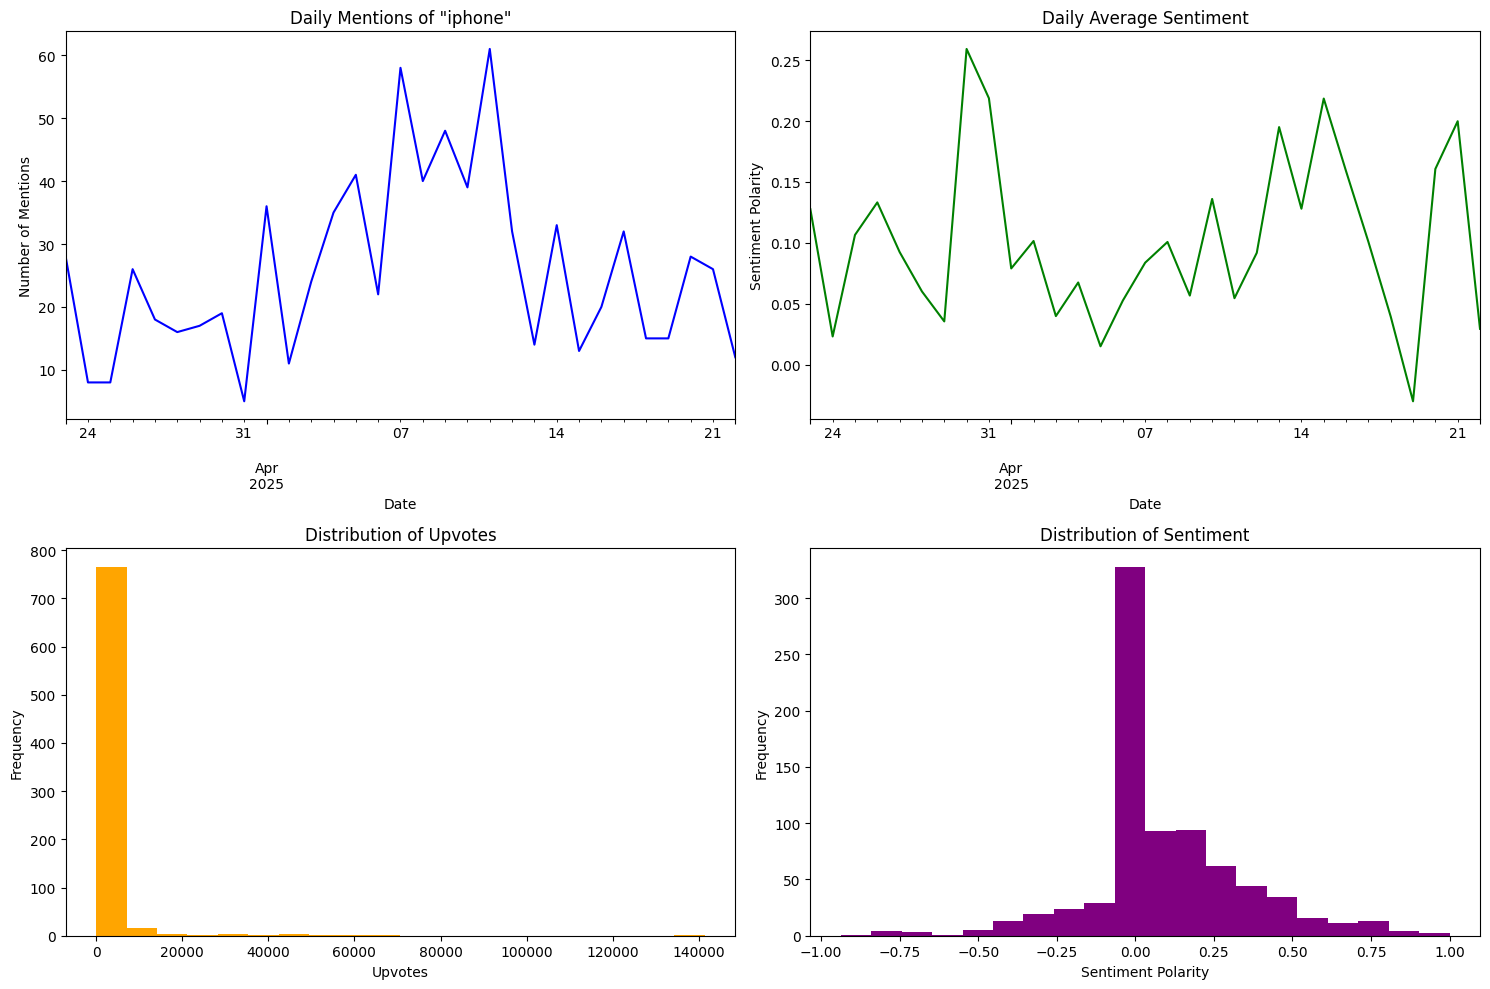


Trend Analysis Summary for 'iphone':
Total mentions collected: 800
Time period covered: 2025-03-23 to 2025-04-22
Average daily mentions: 25.8
Average sentiment score: 0.09
Median upvotes per mention: 275.0

Significant spikes in activity detected on:
- 2025-04-07: 58 mentions
- 2025-04-11: 61 mentions


In [12]:
# Analyze trends
daily_counts = analyze_trends(df.copy(), keyword)

In [13]:
# Identify top contributors
top_contributors = identify_top_contributors(df, top_n=10)
print("\nTop Contributors:")
display(top_contributors)


Top Contributors:


,author,karma,upvotes,sentiment,mentions
203,JaredOlsen8791,954558,141388,0.000,1
427,WinTraditional4038,48881,65951,0.100,1
55,Brian_Ghoshery,1947143,62161,0.000,1
235,Lotr_fan1995,58793,52215,0.000,1
333,Sad_Stay_5471,1155196,45312,0.000,1
198,ItsGettinBreesy,151582,43376,0.400,1
550,imtheoscarmike,10637,42939,0.000,1
632,rightcoastguy,1328843,41948,-0.500,1
74,ChickenLuna,9400,31723,-0.075,1
216,Key_Associate7476,180052,30780,0.000,1


## 7. Additional Analysis


Sentiment by Post Type:


,mean,count
type,,
comment,0.106624,600
post,0.059866,200


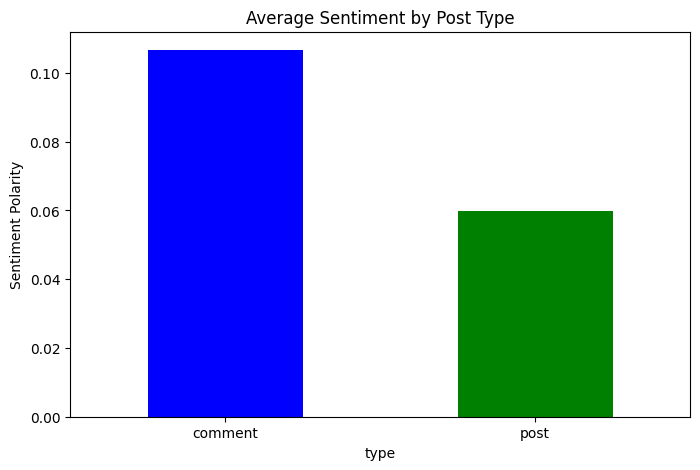

In [14]:
# Sentiment analysis by post type
if 'type' in df.columns:
    print("\nSentiment by Post Type:")
    display(df.groupby('type')['sentiment'].agg(['mean', 'count']))

    # Plot sentiment by type
    plt.figure(figsize=(8, 5))
    df.groupby('type')['sentiment'].mean().plot(kind='bar', color=['blue', 'green'])
    plt.title('Average Sentiment by Post Type')
    plt.ylabel('Sentiment Polarity')
    plt.xticks(rotation=0)
    plt.show()


Correlation Matrix:


,upvotes,karma,sentiment
upvotes,1.000000,0.037731,-0.052789
karma,0.037731,1.000000,-0.043860
sentiment,-0.052789,-0.043860,1.000000


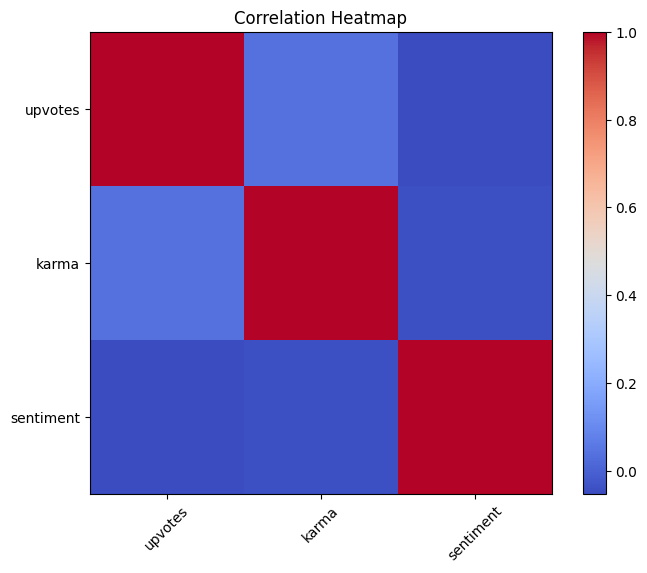

In [15]:
# Correlation analysis
print("\nCorrelation Matrix:")
corr_matrix = df[['upvotes', 'karma', 'sentiment']].corr()
display(corr_matrix)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

## 8. Save Results

In [16]:
# Save dataframe to CSV
df.to_csv(f'{keyword}_mentions_analysis.csv', index=False)
print(f"\nAnalysis results saved to '{keyword}_mentions_analysis.csv'")


Analysis results saved to 'iphone_mentions_analysis.csv'
